In [1]:
import time 
import requests
import cv2
import operator
import numpy as np
from __future__ import print_function

# Import library to display results
import matplotlib.pyplot as plt
%matplotlib inline 
# Display images within Jupyter

In [80]:
# Variables
_projectid = 'a908cc33-6444-4007-8fb2-b45ead19866a' #Here you enter the projectid
_url = 'https://southcentralus.api.cognitive.microsoft.com/customvision/v1.0/Prediction/{}/'.format(_projectid)
_predictionkey = 'cc0bc90005604ff7970162b108d9c32e' #Here you enter the prediction key
_maxNumRetries = 10

# HTTP Request

In [92]:
def processRequest( json, data, headers, params, source):

    """
    Parameters:
    json: Used when processing images from its URL. See API Documentation
    data: Used when processing image read from disk. See API Documentation
    headers: Used to pass the key information and the data type request
    """
    retries = 0
    result = None

    while True:

        response = requests.request( 'post', url = _url+source+"?%s", json = json, data = data, headers = headers, params = params )
        if response.status_code == 429: 

            print( "Message: %s" % ( response.json() ) )

            if retries <= _maxNumRetries: 
                time.sleep(1) 
                retries += 1
                continue
            else: 
                print( 'Error: failed after retrying!' )
                break

        elif response.status_code == 200 or response.status_code == 201:

            if 'content-length' in response.headers and int(response.headers['content-length']) == 0: 
                result = None 
            elif 'content-type' in response.headers and isinstance(response.headers['content-type'], str): 
                if 'application/json' in response.headers['content-type'].lower(): 
                    result = response.json() if response.content else None 
                    #print(result)
                elif 'image' in response.headers['content-type'].lower(): 
                    result = response.content
        else:
            print( "Error code: %d" % ( response.status_code ) )
            print( "Message: %s" % ( response.json() ) )

        break
        
    return result

# 將結果輸出至原圖

In [101]:
def renderResultOnImage( result, img ):
    
    cv2.rectangle( img,(0,0), (img.shape[1], img.shape[0]), color = (255,0,0), thickness = 2 )
    if 'Predictions' in result:
        Prediction = sorted(result['Predictions'], key=lambda x: float(x['Probability']),reverse = True)[0]['Tag']
        Tag = sorted(result['Predictions'], key=lambda x: float(x['Probability']),reverse = True)[0]['Probability']
        cv2.putText( img, str(Prediction), (30,30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2 )
        cv2.putText( img, str(Tag), (30,45), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2 )
        print(Prediction,Tag)

# 讀取圖檔URL並呈現

Cat 1.0


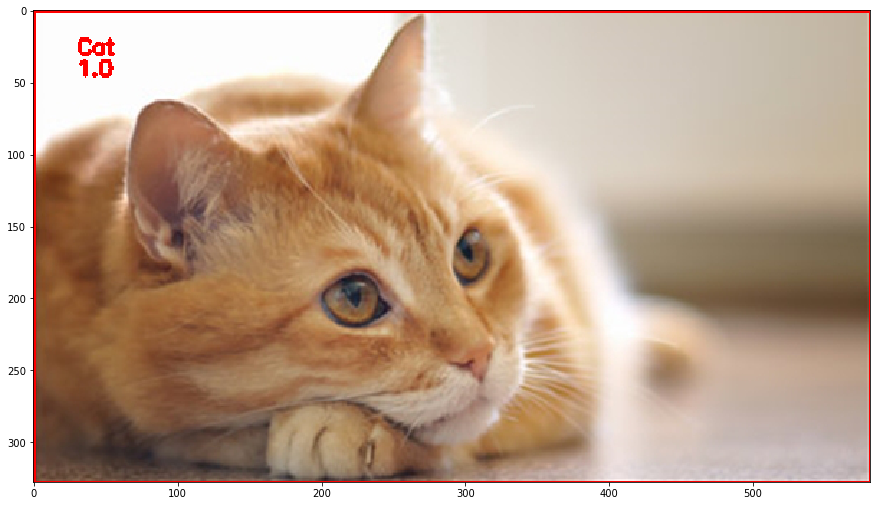

In [102]:
# URL direction to image
urlImage = 'https://www.cats.org.uk/uploads/images/featurebox_sidebar_kids/grief-and-loss.jpg'

# Custom Vision parameters
params = {} 
headers = dict()
headers['Prediction-key'] = _predictionkey
headers['Content-Type'] = 'application/json' 

json = { 'Url': urlImage } 
data = None
#來源改成'url'
result = processRequest( json, data, headers, params ,'url')

if result is not None:
    # Load the original image, fetched from the URL
    arr = np.asarray( bytearray( requests.get( urlImage ).content ), dtype=np.uint8 )
    img = cv2.cvtColor( cv2.imdecode( arr, -1 ), cv2.COLOR_BGR2RGB )
    renderResultOnImage( result, img )
    ig, ax = plt.subplots(figsize=(15, 20))
    ax.imshow( img )

# 從本地端讀取圖檔

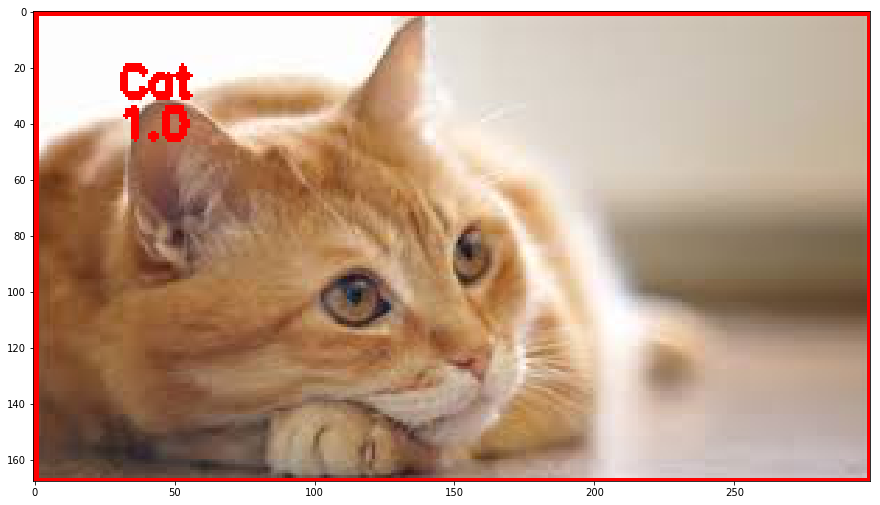

In [95]:
# Load raw image file into memory
pathToFileInDisk = r'/Users/ian/Desktop/DogCat/下載 (3).jpeg'
with open( pathToFileInDisk, 'rb' ) as f:
    data = f.read()

headers = dict()
headers['Prediction-key'] = _predictionkey
headers['Content-Type'] = 'application/octet-stream'

json = None
params = None
#來源改成'image'
result = processRequest( json, data, headers, params ,'image')

if result is not None:
    # Load the original image from disk
    data8uint = np.fromstring( data, np.uint8 ) # Convert string to an unsigned int array
    img = cv2.cvtColor( cv2.imdecode( data8uint, cv2.IMREAD_COLOR ), cv2.COLOR_BGR2RGB )
    renderResultOnImage( result, img )
    ig, ax = plt.subplots(figsize=(15, 20))
    ax.imshow( img )